**Name: Chintan B. Maniyar**
<br>**MACHINE LEARNING - CSCI 8950**
<br>**Homework-4: Back-propogation Neural Network** <br>
<hr>

## Dataset Description

For this homework, I used the *WisconsinBreastCancerDetection* dataset. It contains 9 predictor variables (all encoded) and one target variable which has two classes namely ‘Benign’ and ‘Malignant’, denoted by 2 and 4 respectively. The data was already encoded, however, there were some missing values in one of the predictor variables. Data cleaning was done by dropping the samples (as it was a categorical variable) with any missing values which reduced the sample size from 699 to 683.
<hr>

## Importing Packages

In [203]:
# importing packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from time import time

## Data Preprocessing and Cleaning

In [4]:
# read data

features = ['Clump_Thickness', 'Cell_Size_Uni', 'Cell_Shape_Uni', 'Marginal_Adhesion',
 'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoi', 'Mitoses', 'Class']
bcd = pd.read_csv('./breast_cancer/breast-cancer-wisconsin.data', names=features)
bcd.head()

,Clump_Thickness,Cell_Size_Uni,Cell_Shape_Uni,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoi,Mitoses,Class
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2


In [5]:
bcd.describe()

,Clump_Thickness,Cell_Size_Uni,Cell_Shape_Uni,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoi,Mitoses,Class
count,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000,699.000000
mean,4.417740,3.134478,3.207439,2.806867,3.216023,3.437768,2.866953,1.589413,2.689557
std,2.815741,3.051459,2.971913,2.855379,2.214300,2.438364,3.053634,1.715078,0.951273
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [8]:
# specifying missing values as NaNs
bcd['Bare_Nuclei'] = bcd['Bare_Nuclei'].replace('?', np.NaN)

# dropping tuples with null values
bcd = bcd.dropna()
bcd.describe()

,Clump_Thickness,Cell_Size_Uni,Cell_Shape_Uni,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bland_Chromatin,Normal_Nucleoi,Mitoses,Class
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.445095,2.869693,1.603221,2.699854
std,2.820761,3.065145,2.988581,2.864562,2.223085,2.449697,3.052666,1.732674,0.954592
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


## Train-Test Split and Normalization

In [154]:
X_df = bcd.iloc[:,0:-1]
y_df = bcd.iloc[:,-1].map({2:0, 4:1})

X = X_df.to_numpy()
X = StandardScaler().fit_transform(X)
y = y_df.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [155]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((546, 9), (137, 9), (546,), (137,))

## Building the Model

In [206]:
def buildModel(features_nums, hidden_units):
    input = Input(shape=(features_nums), name='input_layer')
    x = Dense(hidden_units, activation='relu', name='hidden_layer')(input)
    output = Dense(1, activation='sigmoid', name='output_layer')(x)
    
    return Model(inputs=input, outputs=output)

In [209]:
def createModel(input_nums, hidden_nums):
    model = buildModel(input_nums, hidden_nums)
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

In [198]:
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 9)]               0         
_________________________________________________________________
hidden_layer (Dense)         (None, 16)                160       
_________________________________________________________________
output_layer (Dense)         (None, 1)                 17        
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________


## Training Model

In [187]:
%%time
model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Train on 436 samples, validate on 110 samples
Epoch 1/10
436/436 [==============================] - 0s 715us/sample - loss: 0.6573 - acc: 0.7018 - val_loss: 0.5943 - val_acc: 0.7364
Epoch 2/10
436/436 [==============================] - 0s 46us/sample - loss: 0.5331 - acc: 0.7775 - val_loss: 0.4894 - val_acc: 0.8273
Epoch 3/10
436/436 [==============================] - 0s 25us/sample - loss: 0.4454 - acc: 0.8532 - val_loss: 0.4146 - val_acc: 0.8818
Epoch 4/10
436/436 [==============================] - 0s 25us/sample - loss: 0.3816 - acc: 0.9174 - val_loss: 0.3588 - val_acc: 0.9000
Epoch 5/10
436/436 [==============================] - 0s 25us/sample - loss: 0.3328 - acc: 0.9472 - val_loss: 0.3161 - val_acc: 0.9273
Epoch 6/10
436/436 [==============================] - 0s 23us/sample - loss: 0.2951 - acc: 0.9610 - val_loss: 0.2829 - val_acc: 0.9545
Epoch 7/10
436/436 [==============================] - 0s 25us/sample - loss: 0.2655 - acc: 0.9656 - val_loss: 0.2563 - val_acc: 0.9545
Epoch 8/

In [222]:
%%time

history = model.fit(X_train, y_train, epochs=20, batch_size=10, validation_split=0.2, verbose=0)

Wall time: 3.48 s


In [191]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [178]:
model.evaluate(X_test, y_test)

137/137 [==============================] - 0s 612us/sample - loss: 0.0821 - acc: 0.9708


[0.08213309611934815, 0.9708029]

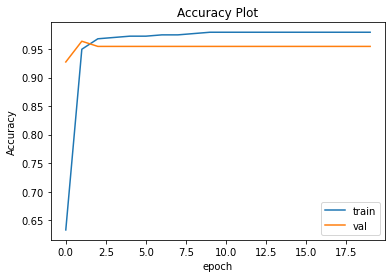

In [225]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

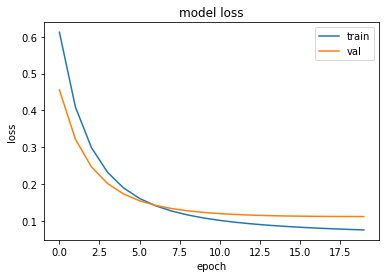

In [226]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [237]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

X = X_train 
Y = y_train

hidden_units = [5,10,15,20,25,30,35,40]
models = []
max_times = []
results = {}

for num_hidden_units in hidden_units:
    print('Hidden Units: %d' % num_hidden_units)
    # define 10-fold cross validation test harness
    kfold = StratifiedKFold(n_splits=10, shuffle=True,random_state=seed) 
    cvscores = []
    times = []
    for train, test in kfold.split(X, Y):
        model = createModel(X_train.shape[1], num_hidden_units)
        models.append(model)

        start = time()
        model.fit(X[train], Y[train], epochs=20, batch_size=10, verbose=0)
        end = time()
        times.append(end-start)

        scores = model.evaluate(X[test], Y[test], verbose=0)
        print("%s: %.2f" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
    
    best_model = np.array(cvscores).argmax()
    max_times.append(max(times))
    
    print("Training/CV: %.2f (+/- %.2f)" % (np.mean(cvscores), np.std(cvscores)))
    print("Testing (best model): %.2f" % (models[-1].evaluate(X_test, y_test, verbose=0)[1]*100))
    print("Time: %.2f" % max(times))
    print('****************************************************************************')
    results[num_hidden_units] = {'cvscores': cvscores, 'times': times, 'cvmean':np.mean(cvscores), 'cvstd':np.std(cvscores)}

Hidden Units: 5
acc: 92.73
acc: 98.18
acc: 100.00
acc: 94.55
acc: 98.18
acc: 100.00
acc: 90.74
acc: 100.00
acc: 96.30
acc: 98.15
Training/CV: 96.88 (+/- 3.08)
Testing (best model): 95.62
Time: 8.29
****************************************************************************
Hidden Units: 10
acc: 92.73
acc: 100.00
acc: 98.18
acc: 92.73
acc: 98.18
acc: 100.00
acc: 94.44
acc: 100.00
acc: 96.30
acc: 98.15
Training/CV: 97.07 (+/- 2.73)
Testing (best model): 97.81
Time: 7.96
****************************************************************************
Hidden Units: 15
acc: 92.73
acc: 96.36
acc: 100.00
acc: 90.91
acc: 98.18
acc: 100.00
acc: 96.30
acc: 100.00
acc: 94.44
acc: 98.15
Training/CV: 96.71 (+/- 3.03)
Testing (best model): 98.54
Time: 8.17
****************************************************************************
Hidden Units: 20
acc: 92.73
acc: 96.36
acc: 98.18
acc: 90.91
acc: 98.18
acc: 100.00
acc: 94.44
acc: 100.00
acc: 94.44
acc: 98.15
Training/CV: 96.34 (+/- 2.94)
Testing (best 

In [218]:
np.array(cvscores).argmax()

2

In [236]:
times

[7.220893144607544,
 7.141753435134888,
 7.240206718444824,
 7.274754285812378,
 7.834929466247559,
 7.199885845184326,
 7.443694829940796,
 7.4552154541015625,
 7.494878053665161,
 7.529874801635742]

Text(0, 0.5, 'Training Time (s)')

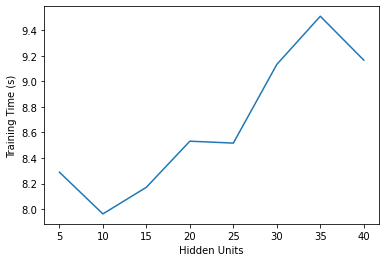

In [240]:
plt.plot(max_times)
plt.xlabel('Hidden Units')
plt.xticks(range(8), ['5','10','15','20','25','30','35','40'])
plt.ylabel('Training Time (s)')

In [ ]:
plt.plot(max_times)
plt.xlabel('Hidden Units')
plt.xticks(range(8), ['5','10','15','20','25','30','35','40'])
plt.ylabel('Time (s)')